In [54]:
from __future__ import annotations
import typing
import json
import pathlib
import os
import time
import datetime

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_

import transformers
import transformers.modeling_outputs
from transformers import AutoTokenizer, AutoModel

from nltk.corpus import stopwords

import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

from tqdm import tqdm

import IPython
from IPython.display import display

In [55]:
IS_KAGGLE = "KAGGLE_DOCKER_IMAGE" in os.environ

DATASETS = pathlib.Path(
    "."
    if not IS_KAGGLE
    else "/kaggle/input/influencers-or-observers-predicting-social-roles/Kaggle2025"
)

DATASET_TRAIN = DATASETS / "train.jsonl"
DATASET_KAGGLE = DATASETS / "kaggle_test.jsonl"

CACHE_DIR = pathlib.Path(".")

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [57]:
torch.random.manual_seed(42)
np.random.seed(42)

# Data loading

In [58]:
def load_json(path: pathlib.Path, cache: bool = False) -> pd.DataFrame:
    path_pq = (CACHE_DIR / path.name).with_stem(f"{path.stem}_raw").with_suffix(".parquet")
    
    if cache and path_pq.exists():
        return pd.read_parquet(path_pq)
    
    # This leaves things to be desired, since there's no way to specify dtypes
    # and it assumes float instead of int, causing a loss in precision...
    # But I guess it only matters for ids, which we'll probably discard in preprocessing anyway
    result = pd.json_normalize(list(map(json.loads, path.read_bytes().splitlines())))
    
    if cache:
        result.to_parquet(path_pq)
    
    return result


In [59]:
train_data = load_json(DATASET_TRAIN, cache=True)
kaggle_data = load_json(DATASET_KAGGLE, cache=True)

# Preprocessing

In [60]:

def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df["is_reply"] = df["in_reply_to_status_id"].notna()
    
    df = df.drop(columns=[
        "in_reply_to_status_id_str",
        # "in_reply_to_status_id",
        "in_reply_to_user_id_str",
        "in_reply_to_user_id",
        "quoted_status_id_str",
        "quoted_status_id",
        "id_str",
        "quoted_status.in_reply_to_status_id_str",
        "quoted_status.in_reply_to_status_id",
        "quoted_status.in_reply_to_user_id_str",
        "quoted_status.in_reply_to_user_id",
        "quoted_status.id_str",
        "quoted_status.id",
        "quoted_status.user.id_str",
        "quoted_status.user.id",
        # "quoted_status_permalink.expanded",
        "quoted_status_permalink.display",
        "quoted_status_permalink.url",
        "quoted_status.quoted_status_id",
        "quoted_status.quoted_status_id_str",
        # "quoted_status.place.id",
        # "place.id",
        "lang",  # Always "fr"
        "retweeted",  # Always False
        "filter_level",  # Always "low"
        "geo",  # Always None
        "place",  # Always None
        "coordinates",  # Always None
        "contributors",  # Always None
        "quote_count",  # Always 0
        "reply_count",  # Always 0
        "retweet_count",  # Always 0
        "favorite_count",  # Always 0
        "favorited",  # Always False
        "quoted_status.geo",  # Always None
        "quoted_status.place",  # Always None
        "quoted_status.coordinates",  # Always None
        "quoted_status.retweeted",  # Always False
        "quoted_status.filter_level",  # Always "low"
        "quoted_status.contributors",  # Always None
        "quoted_status.user.utc_offset",  # Always None
        "quoted_status.user.lang",  # Always None
        "quoted_status.user.time_zone",  # Always None
        "quoted_status.user.follow_request_sent",  # Always None
        "quoted_status.user.following",  # Always None
        "quoted_status.user.notifications",  # Always None
        "user.default_profile_image",  # Always False
        "user.protected",  # Always False
        "user.contributors_enabled",  # Always False
        "user.lang",  # Always None
        "user.notifications",  # Always None
        "user.following",  # Always None
        "user.utc_offset",  # Always None
        "user.time_zone",  # Always None
        "user.follow_request_sent",  # Always None
    ])
    
    df["full_text"] = df.apply(lambda tweet: extract_full_text(tweet), axis=1)
    
    source_split = df["source"].str.removeprefix("<a href=\"").str.removesuffix("</a>").str.split("\" rel=\"nofollow\">").map(lambda x: x if len(x) == 2 else pd.NA)
    df["source.url"] = source_split.map(lambda x: x[0], na_action="ignore")
    df["source.name"] =source_split.map(lambda x: x[1], na_action="ignore")
    
    return df


def extract_full_text(tweet: pd.Series) -> str:
    text: str = tweet["text"]
    
    if not pd.isna(tweet["extended_tweet.full_text"]):
        text = tweet["extended_tweet.full_text"]
    
    return text


In [61]:
X_train = train_data.drop("label", axis=1)
y_train = train_data["label"]

X_kaggle = kaggle_data

X_train = preprocess(X_train)
X_kaggle = preprocess(X_kaggle)

# Data exploration

In [62]:
train_data[[
    "in_reply_to_status_id_str",
    "in_reply_to_status_id",
    "in_reply_to_user_id_str",
    "in_reply_to_user_id",
    "quoted_status_id_str",
    "quoted_status_id",
    "id_str",
    "quoted_status.in_reply_to_status_id_str",
    "quoted_status.in_reply_to_status_id",
    "quoted_status.in_reply_to_user_id_str",
    "quoted_status.in_reply_to_user_id",
    "quoted_status.id_str",
    "quoted_status.id",
    "quoted_status.user.id_str",
    "quoted_status.user.id",
    "quoted_status.quoted_status_id",
    "quoted_status.quoted_status_id_str",
]].map(lambda x: float(x) if isinstance(x, str) else x).corrwith(y_train)

in_reply_to_status_id_str                 -0.050524
in_reply_to_status_id                     -0.050524
in_reply_to_user_id_str                   -0.008360
in_reply_to_user_id                       -0.008360
quoted_status_id_str                      -0.019543
quoted_status_id                          -0.019543
id_str                                    -0.026025
quoted_status.in_reply_to_status_id_str   -0.029068
quoted_status.in_reply_to_status_id       -0.029068
quoted_status.in_reply_to_user_id_str     -0.026719
quoted_status.in_reply_to_user_id         -0.026719
quoted_status.id_str                      -0.019542
quoted_status.id                          -0.019542
quoted_status.user.id_str                  0.018087
quoted_status.user.id                      0.018087
quoted_status.quoted_status_id            -0.022994
quoted_status.quoted_status_id_str        -0.022994
dtype: float64

In [63]:
train_data[[
    "quoted_status.place.id",
    "place.id",
]].map(lambda x: int(x, base=16) if isinstance(x, str) else x).corrwith(y_train)

quoted_status.place.id    0.043506
place.id                 -0.044059
dtype: float64

In [64]:
train_data[[
    "quoted_status_permalink.expanded",
    "quoted_status_permalink.display",
    "quoted_status_permalink.url",
]].map(lambda x: len(x) if isinstance(x, str) else x).corrwith(y_train)

c:\Program Files\Python310\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Program Files\Python310\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


quoted_status_permalink.expanded   -0.037841
quoted_status_permalink.display     0.000148
quoted_status_permalink.url              NaN
dtype: float64

In [65]:
X_train.corrwith(y_train, numeric_only=True)

in_reply_to_status_id                 -0.050524
is_quote_status                       -0.018314
truncated                             -0.009665
challenge_id                           0.001228
quoted_status.retweet_count            0.017500
quoted_status.favorite_count           0.017766
quoted_status.quote_count              0.046755
quoted_status.reply_count              0.007355
quoted_status.user.friends_count      -0.019404
quoted_status.user.listed_count        0.001474
quoted_status.user.favourites_count   -0.050869
quoted_status.user.statuses_count     -0.000199
quoted_status.user.followers_count     0.007178
user.listed_count                      0.078584
user.favourites_count                  0.146453
user.is_translator                     0.013591
user.geo_enabled                       0.296986
user.profile_background_tile           0.180543
user.statuses_count                    0.281050
user.profile_use_background_image     -0.129781
user.default_profile                  -0

In [66]:
dt_cols = X_train[:10].apply(lambda col: pd.to_datetime(col, format="%a %b %d %H:%M:%S %z %Y", errors="coerce"))
dt_cols = dt_cols.columns[dt_cols.notna().any()]

pd.Series({
    col: X_train[col].apply(lambda x: time.mktime(time.strptime(x, "%a %b %d %H:%M:%S %z %Y")) if pd.notnull(x) else pd.NA).corr(y_train)
    for col in dt_cols
})

created_at                      -0.026027
quoted_status.created_at        -0.018908
quoted_status.user.created_at    0.021092
user.created_at                 -0.291983
dtype: float64

In [67]:
def safe_len(x: typing.Any) -> int | float:
    try:
        return len(x)
    except TypeError:
        return pd.NA

In [68]:
len_cols = X_train[:10].apply(lambda col: col.map(safe_len))
len_cols = len_cols.columns[len_cols.notna().any()]

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.Series({
        f"len({col})": X_train[col].apply(safe_len).fillna(0).corr(y_train)
        for col in len_cols
    }))

c:\Program Files\Python310\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Program Files\Python310\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\Abel\AppData\Local\Temp\ipykernel_13616\4087167509.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  f"len({col})": X_train[col].apply(safe_len).fillna(0).corr(y_train)


len(created_at)                                                    NaN
len(source)                                                  -0.084287
len(in_reply_to_screen_name)                                 -0.217397
len(text)                                                    -0.011660
len(timestamp_ms)                                                  NaN
len(quoted_status.extended_tweet.entities.urls)              -0.031582
len(quoted_status.extended_tweet.entities.hashtags)          -0.000267
len(quoted_status.extended_tweet.entities.user_mentions)     -0.015762
len(quoted_status.extended_tweet.entities.symbols)            0.004725
len(quoted_status.extended_tweet.full_text)                  -0.031543
len(quoted_status.extended_tweet.display_text_range)         -0.027365
len(quoted_status.created_at)                                -0.018283
len(quoted_status.source)                                    -0.014854
len(quoted_status.text)                                      -0.023169
len(qu

<AxesSubplot: >

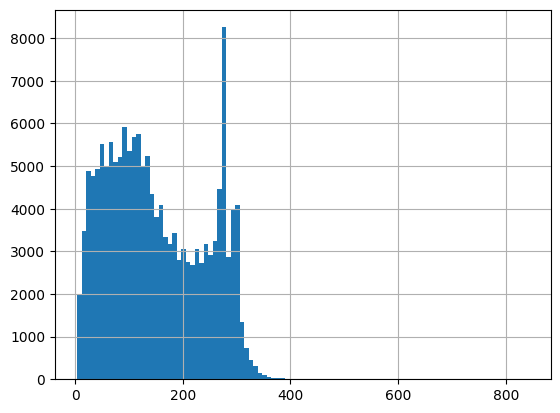

In [69]:
X_train["full_text"].apply(safe_len).hist(bins=100)

<AxesSubplot: >

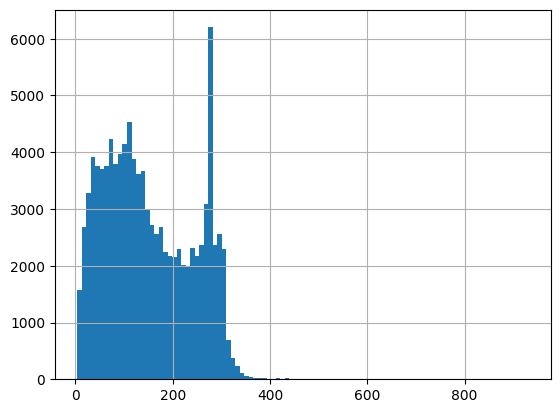

In [70]:
X_kaggle["full_text"].apply(safe_len).hist(bins=100)

In [71]:
for col in [
    # "full_text",
    # "user.description",
    "source",
    "in_reply_to_screen_name",
    "quoted_status.user.screen_name",
    "quoted_status.user.name",
]:
    train_values = set(X_train[col].unique())
    infer_values = set(X_kaggle[col].unique())
    print(
        f"{len(train_values)} vs {len(infer_values)}; {len(train_values & infer_values)} common, {len(infer_values - train_values)} new. "
        f"Average len: {X_train[col].dropna().map(len).mean():.2f} vs {X_kaggle[col].dropna().map(len).mean():.2f}"
    )
    del train_values, infer_values

409 vs 279; 116 common, 163 new. Average len: 78.23 vs 78.26
26282 vs 19130; 5590 common, 13540 new. Average len: 10.56 vs 10.55
12868 vs 9461; 3762 common, 5699 new. Average len: 10.32 vs 10.29
12995 vs 9554; 3805 common, 5749 new. Average len: 12.71 vs 12.69


# Models

In [123]:
# Made this a class to hold all the caches. It may resemble an nn.Module, but isn't one!
class FeatureExtractor:
    training: bool
    device: torch.device
    means: pd.Series | None
    stds: pd.Series | None
    afm_cache: dict[tuple[str, str], float]
    text_encoder_name: str | None
    text_tokenizer: nn.Module | None
    text_encoder: nn.Module | None
    text_enc_cache_path: pathlib.Path | None
    
    def __init__(self, text_encoder_name: str | None = None, text_enc_cache_path: pathlib.Path | None = None, device: torch.device = device):
        super().__init__()
        self.device = device
        self.means = None
        self.stds = None
        self.afm_cache = {}
        self.text_enc_cache_path = text_enc_cache_path
        
        self.text_encoder_name = text_encoder_name
        self.text_tokenizer = None
        self.text_encoder = None
        
        if text_encoder_name is not None:
            self.text_tokenizer = AutoTokenizer.from_pretrained(text_encoder_name)
            if hasattr(self.text_tokenizer, "to"):  # Distilbert doesn't, apprently
                self.text_tokenizer = self.text_tokenizer.to(self.device)
            self.text_encoder = AutoModel.from_pretrained(text_encoder_name).to(self.device)
        
        self.train()
    
    def train(self):
        self.training = True
    
    def eval(self):
        self.training = False
    
    def state_dict(self):
        return {
            "means": self.means,
            "stds": self.stds,
            "afm_cache": self.afm_cache,
        }
    
    def load_state_dict(self, state_dict):
        self.means = state_dict["means"]
        self.stds = state_dict["stds"]
        self.afm_cache = state_dict["afm_cache"]
    
    def extract(self, df: pd.DataFrame, override_cache: bool = False) -> torch.Tensor:
        md_cols: list[pd.Series] = []

        for fn, col_name in tqdm(self.METADATA_FIELDS, desc="Extracting metadata"):
            md_cols.append(fn(self, df[col_name]))
        
        md: pd.DataFrame = pd.concat(md_cols, axis=1)
        
        # The second case shouldn't be triggered, but sometimes the preprocessor used during training is lost
        if self.training:
            self.means = md.mean().fillna(0)
            self.stds = md.std().fillna(1)
        
        assert self.means is not None and self.stds is not None, "You forgot to train/load the feature extractor"

        md = (md - self.means) / self.stds

        md_tensor = torch.from_numpy(md.to_numpy()).float().to(self.device)
        
        # return torch.cat([md_tensor, torch.zeros(len(df), self.dim_txt, device=self.device)], dim=1)
        
        txt_cols: list[torch.Tensor] = []
        
        if self.text_enc_cache_path is None:
            for col_name in self.TEXT_FIELDS:
                txt_cols.append(self.embed_texts(df[col_name]))
        else:
            cf = self.text_enc_cache_path / ("train.ckpt" if self.training else "infer.ckpt")
            cf.parent.mkdir(parents=True, exist_ok=True)
            
            if cf.exists() and not override_cache:
                encodings = torch.load(cf)
                for col_name in self.TEXT_FIELDS:
                    txt_cols.append(encodings[col_name].to(self.device))
            else:
                for col_name in self.TEXT_FIELDS:
                    txt_cols.append(self.embed_texts(df[col_name]))
                
                torch.save({
                    field: embedding.cpu().detach()
                    for field, embedding in zip(self.TEXT_FIELDS, txt_cols)
                }, cf)
        
        txt_tensor = torch.cat(txt_cols, dim=1)
        
        return torch.cat([md_tensor, txt_tensor], dim=1)
    
    @property
    def dim(self) -> int:
        return self.dim_md + self.dim_txt
    
    @property
    def dim_md(self) -> int:
        return len(self.METADATA_FIELDS)
    
    @property
    def dim_txt(self) -> int:
        return len(self.TEXT_FIELDS) * self.embed_size
    
    @property
    def embed_size(self) -> int:
        return self.text_encoder.config.hidden_size
    
    def apply_fill_mean(
        self,
        col: pd.Series,
        func: typing.Callable[[typing.Any], typing.Any],
    ) -> pd.Series:
        col = col.map(func, na_action="ignore")
        
        key = (col.name, func.__name__)
        if self.training:
            self.afm_cache[key] = col.mean()
        
        return col.fillna(self.afm_cache[key])
    
    def md_bool(self, col: pd.Series) -> pd.Series:
        return col.map(lambda x: (1 if x else -1), na_action="ignore").fillna(0)

    def md_len(self, col: pd.Series) -> pd.Series:
        return col.map(len, na_action="ignore").fillna(0)

    def md_time(self, col: pd.Series) -> pd.Series:
        return self.apply_fill_mean(col, lambda x: time.mktime(time.strptime(x, "%a %b %d %H:%M:%S %z %Y")))

    def md_num(self, col: pd.Series) -> pd.Series:
        return self.apply_fill_mean(col, pd.to_numeric)

    def md_place(self, col: pd.Series) -> pd.Series:
        return col.map(lambda x: int(x, 16), na_action="ignore").fillna(0)
    
    METADATA_FIELDS: list[tuple[typing.Callable[[FeatureExtractor, pd.Series], pd.Series], str]] = [
        (md_bool, "is_quote_status"),
        (md_bool, "is_reply"),
        (md_bool, "possibly_sensitive"),
        (md_bool, "quoted_status.user.verified"),
        (md_bool, "user.is_translator"),
        (md_bool, "user.geo_enabled"),
        (md_bool, "user.profile_use_background_image"),
        (md_bool, "user.default_profile"),
        
        (md_len, "full_text"),
        (md_len, "source.name"),
        (md_len, "in_reply_to_screen_name"),
        (md_len, "quoted_status.extended_tweet.entities.urls"),
        (md_len, "quoted_status.extended_tweet.entities.user_mentions"),
        (md_len, "quoted_status.extended_tweet.full_text"),
        (md_len, "quoted_status.entities.urls"),
        (md_len, "quoted_status.user.profile_image_url_https"),
        (md_len, "quoted_status.user.profile_background_image_url"),
        (md_len, "quoted_status.user.profile_background_image_url_https"),
        (md_len, "quoted_status.user.screen_name"),
        (md_len, "quoted_status.user.name"),
        (md_len, "entities.hashtags"),
        (md_len, "entities.user_mentions"),
        (md_len, "user.profile_image_url_https"),
        (md_len, "user.profile_background_image_url"),
        (md_len, "user.description"),
        (md_len, "user.translator_type"),
        (md_len, "user.url"),
        (md_len, "user.profile_banner_url"),
        (md_len, "user.location"),
        (md_len, "display_text_range"),
        (md_len, "extended_tweet.entities.urls"),
        (md_len, "extended_tweet.entities.hashtags"),
        (md_len, "extended_tweet.entities.user_mentions"),
        (md_len, "quoted_status_permalink.expanded"),
        
        (md_time, "created_at"),
        (md_time, "user.created_at"),
        (md_time, "quoted_status.created_at"),
        (md_time, "quoted_status.user.created_at"),
        
        (md_num, "user.statuses_count"),
        (md_num, "user.listed_count"),
        (md_num, "user.favourites_count"),
        (md_num, "user.profile_background_tile"),
        (md_num, "quoted_status.quote_count"),
        (md_num, "quoted_status.user.followers_count"),
        (md_num, "quoted_status.user.favourites_count"),
        (md_num, "in_reply_to_status_id"),
        
        (md_place, "quoted_status.place.id"),
        (md_place, "place.id"),
    ]

    def embed_texts(
        self,
        texts: pd.Series,
        batch_size: int = 64,
        progress: bool = True
    ) -> torch.Tensor:
        tokenizer = self.text_tokenizer
        encoder = self.text_encoder
        encoder.eval()

        all_embeddings = []

        with torch.no_grad():
            batch_offsets = range(0, len(texts), batch_size)
            if progress:
                batch_offsets = tqdm(batch_offsets, desc=f"Embedding {texts.name or '<unnamed>'}")
            for i in batch_offsets:
                batch_texts = texts.iloc[i:i + batch_size]
                nonna = batch_texts.notna() & batch_texts.str.len().gt(0)

                tokenized = tokenizer(
                    batch_texts[nonna].tolist(),
                    padding=True,
                    truncation=True,
                    return_tensors="pt",
                ).to(self.device)

                outputs: transformers.modeling_outputs.BaseModelOutput = encoder(**tokenized)
                last_hidden: torch.Tensor = outputs.last_hidden_state
                mask: torch.Tensor = tokenized["attention_mask"].unsqueeze(-1)
                
                masked_hidden = last_hidden * mask
                summed = masked_hidden.sum(dim=1)
                counts = mask.sum(dim=1)
                embeddings = torch.zeros(len(batch_texts), last_hidden.shape[2], device=self.device)
                nonna = nonna.reset_index(drop=True)
                embeddings[nonna[nonna].index] = (summed / counts)

                all_embeddings.append(embeddings)

        return torch.cat(all_embeddings, dim=0)

    TEXT_FIELDS: list[str | typing.Callable[[pd.DataFrame], pd.Series]] = [
        "full_text",
        "user.description",
        # lambda df: df.apply(lambda x: "via: {0}, reply: @{1}; quote: @{2} {3}".format(x["source.name"], x["in_reply_to_screen_name"], x["quoted_status.user.screen_name"], x["quoted_status.user.name"])),
    ]


In [124]:
class TweetDataset(Dataset):
    features: torch.Tensor
    labels: torch.Tensor
    device: torch.device
    
    def __init__(
        self,
        feature_extractor: FeatureExtractor,
        df: pd.DataFrame,
        labels: pd.Series,
        device: torch.device = device,
    ):
        self.features = feature_extractor.extract(df)
        self.labels = torch.tensor(labels, dtype=torch.long, device=device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            "features": self.features[idx],
            "label": self.labels[idx],
        }


def collate_fn(batch):
    features = torch.stack([x["features"] for x in batch])
    labels = torch.stack([x["label"] for x in batch])
    return features, labels


In [125]:
NUM_CLASSES = 2

class TweetClassifier(nn.Module):
    num_features: int
    dropout: nn.Module
    fc1: nn.Module
    fc2: nn.Module
    fc3: nn.Module
    
    def __init__(
        self,
        num_features: int,
        hidden_dim: int = 512,
    ):
        super().__init__()

        self.num_features = num_features
        
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, NUM_CLASSES)
    
    @property
    def device(self) -> torch.device:
        return next(self.parameters()).device
    
    def forward(self, x: torch.Tensor) -> dict[str, torch.Tensor]:
        """
        Returns dict with:
            "logits": tensor [batch_size, num_classes]
            "probs": tensor [batch_size, num_classes]
        """
        batch_size = len(x)
        
        assert x.shape == (batch_size, self.num_features)
        
        x = self.dropout(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        probs = F.softmax(logits, dim=-1)

        return {
            "logits": logits,
            "probs": probs,
        }


In [126]:
def train_model(
    model: TweetClassifier,
    train_ds: Dataset,
    val_ds: Dataset,
    epochs: int = 3,
    lr: float = 2e-4,
    weight_decay: float = 0.01,
    max_grad_norm: float = 1.0,
    device: torch.device = device,
    batch_size: int = 32,
    optimizer: torch.optim.Optimizer | None = None,
    checkpoints_path: pathlib.Path | str | None = ".",
    return_best: bool = False,
) -> TweetClassifier:
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )
    
    model.to(device)
    if optimizer is None:
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    criterion = torch.nn.CrossEntropyLoss()
    
    best_val_loss = float("inf")
    best_model_file: pathlib.Path | None = None

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")
        model.train()
        total_loss = 0.0

        status_bar = tqdm(train_loader, desc="Training")

        for features, labels in status_bar:
            features: torch.Tensor
            labels: torch.Tensor
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad(set_to_none=True)

            out = model(features)
            logits = out["logits"]
            
            loss: torch.Tensor = criterion(logits, labels)
            loss.backward()
            clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            total_loss += loss.item()
            status_bar.set_postfix({"loss": total_loss / (status_bar.n + 1)})
        
        print(f"Train Loss: {total_loss / len(train_loader):.4f}")
        
        val_metrics = evaluate_model(
            model=model,
            val_ds=val_ds,
            device=device,
            batch_size=batch_size,
        )

        print(f"Val Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['acc']:.4f}")

        if checkpoints_path is not None:
            ckpt = pathlib.Path(checkpoints_path) / f"epoch_{epoch:02}.pt"
            torch.save(model.state_dict(), ckpt)
            print(f"Checkpoint saved to {ckpt}")
            
            if val_metrics["loss"] < best_val_loss:
                best_val_loss = val_metrics["loss"]
                best_model_file = ckpt

    if return_best and best_model_file is not None:
        print(f"Best model: {best_model_file}")
        model.load_state_dict(torch.load(best_model_file))
    
    return model


def evaluate_model(
    model: TweetClassifier,
    val_ds: Dataset,
    device: torch.device = device,
    batch_size: int = 32,
) -> tuple[float, float]:
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
    )
    
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()

    total_loss = 0.0
    correct = 0
    count = 0

    with torch.no_grad():
        status_bar = tqdm(val_loader, desc="Evaluating")
        
        for features, labels in status_bar:
            features: torch.Tensor
            labels: torch.Tensor
            features = features.to(device)
            labels = labels.to(device)

            out = model(features)
            logits: torch.Tensor = out["logits"]
            
            loss: torch.Tensor = criterion(logits, labels)
            total_loss += loss.item()
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            count += labels.size(0)
            
            status_bar.set_postfix({"loss": total_loss / (status_bar.n + 1), "acc": correct / count})

    return {
        "loss": total_loss / len(val_loader),
        "acc": correct / count,
    }


In [127]:
def infer_with_model(
    model: TweetClassifier,
    feature_extractor: FeatureExtractor,
    df: pd.DataFrame,
    out_file: pathlib.Path | str | None = None,
    device: torch.device = device,
    batch_size: int = 32,
) -> torch.Tensor:
    feature_extractor.eval()
    
    data_loader = DataLoader(
        TweetDataset(feature_extractor, df, torch.zeros(len(df), dtype=torch.long, device=device), device=device),
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
    )
    
    model.eval()
    
    predictions = torch.zeros(len(df), dtype=torch.long)
    cur_idx = 0
    
    with torch.no_grad():
        for features, _ in tqdm(data_loader, desc="Inferring"):
            features: torch.Tensor
            features = features.to(device)

            out = model(features)
            logits: torch.Tensor = out["logits"].cpu()
            
            predictions[cur_idx:cur_idx+len(features)] = logits.argmax(dim=-1)
            cur_idx += len(features)
    
    if out_file is not None:
        output = pd.concat([df["challenge_id"], pd.DataFrame(predictions)], axis=1, ignore_index=True)
        output.columns = ["ID", "Prediction"]
        output.to_csv(out_file, index=False)
    
    return predictions


In [128]:
def run_with_text_encoder(text_encoder_name: str):
    print(f"\n===== [ {text_encoder_name} ] =====\n")
    
    model_folder = pathlib.Path("./models/v8/") / text_encoder_name.split("/")[-1]
    model_folder.mkdir(exist_ok=True, parents=True)
    
    feature_extractor = FeatureExtractor(text_encoder_name=text_encoder_name, text_enc_cache_path=model_folder / "text_enc_cache", device=device)

    feature_extractor.train()
    full_train_ds = TweetDataset(feature_extractor, X_train, y_train, device=device)
    
    torch.save(feature_extractor.state_dict(), model_folder / "feature_extractor.ckpt")

    train_ds, val_ds = random_split(full_train_ds, [0.9, 0.1])
    
    model = TweetClassifier(
        num_features=feature_extractor.dim,
        hidden_dim=512,
    ).to(device)
    
    model = train_model(model, train_ds, val_ds, lr=2e-4, epochs=10, batch_size=64, device=device, checkpoints_path=model_folder, return_best=True)
    torch.save(model.state_dict(), model_folder / "best_model.ckpt")
    torch.cuda.empty_cache()
    infer_with_model(model, feature_extractor, X_kaggle, batch_size=64, device=device, out_file=model_folder / "predictions-v8.csv")
    torch.cuda.empty_cache()


In [130]:
run_with_text_encoder("distilbert/distilbert-base-cased")


===== [ distilbert/distilbert-base-cased ] =====



Extracting metadata:  19%|█▉        | 9/48 [00:00<00:01, 29.72it/s]C:\Users\Abel\AppData\Local\Temp\ipykernel_13616\1823344070.py:131: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return col.map(len, na_action="ignore").fillna(0)
Extracting metadata: 100%|██████████| 48/48 [00:08<00:00,  5.87it/s]


Epoch 1/10


Training: 100%|██████████| 2179/2179 [00:12<00:00, 179.88it/s, loss=0.469]


Train Loss: 0.4658


Evaluating: 100%|██████████| 243/243 [00:00<00:00, 299.84it/s, loss=0.453, acc=0.806]


Val Loss: 0.4254, Acc: 0.8056
Checkpoint saved to models\v8\distilbert-base-cased\epoch_01.pt
Epoch 2/10


Training: 100%|██████████| 2179/2179 [00:12<00:00, 174.38it/s, loss=0.43] 


Train Loss: 0.4285


Evaluating: 100%|██████████| 243/243 [00:00<00:00, 263.34it/s, loss=0.416, acc=0.814]


Val Loss: 0.4109, Acc: 0.8136
Checkpoint saved to models\v8\distilbert-base-cased\epoch_02.pt
Epoch 3/10


Training: 100%|██████████| 2179/2179 [00:12<00:00, 174.80it/s, loss=0.416]


Train Loss: 0.4128


Evaluating: 100%|██████████| 243/243 [00:00<00:00, 297.21it/s, loss=0.444, acc=0.821]


Val Loss: 0.3928, Acc: 0.8211
Checkpoint saved to models\v8\distilbert-base-cased\epoch_03.pt
Epoch 4/10


Training: 100%|██████████| 2179/2179 [00:12<00:00, 172.72it/s, loss=0.406]


Train Loss: 0.4036


Evaluating: 100%|██████████| 243/243 [00:00<00:00, 284.28it/s, loss=0.401, acc=0.826]


Val Loss: 0.3909, Acc: 0.8262
Checkpoint saved to models\v8\distilbert-base-cased\epoch_04.pt
Epoch 5/10


Training: 100%|██████████| 2179/2179 [00:12<00:00, 168.79it/s, loss=0.394]


Train Loss: 0.3917


Evaluating: 100%|██████████| 243/243 [00:00<00:00, 288.19it/s, loss=0.401, acc=0.822]


Val Loss: 0.4007, Acc: 0.8218
Checkpoint saved to models\v8\distilbert-base-cased\epoch_05.pt
Epoch 6/10


Training: 100%|██████████| 2179/2179 [00:13<00:00, 162.89it/s, loss=0.383]


Train Loss: 0.3805


Evaluating: 100%|██████████| 243/243 [00:00<00:00, 269.21it/s, loss=0.391, acc=0.839]


Val Loss: 0.3720, Acc: 0.8389
Checkpoint saved to models\v8\distilbert-base-cased\epoch_06.pt
Epoch 7/10


Training: 100%|██████████| 2179/2179 [00:12<00:00, 168.34it/s, loss=0.369]


Train Loss: 0.3683


Evaluating: 100%|██████████| 243/243 [00:00<00:00, 284.71it/s, loss=0.397, acc=0.836]


Val Loss: 0.3723, Acc: 0.8358
Checkpoint saved to models\v8\distilbert-base-cased\epoch_07.pt
Epoch 8/10


Training: 100%|██████████| 2179/2179 [00:14<00:00, 151.13it/s, loss=0.358]


Train Loss: 0.3582


Evaluating: 100%|██████████| 243/243 [00:01<00:00, 221.55it/s, loss=0.366, acc=0.842]


Val Loss: 0.3600, Acc: 0.8416
Checkpoint saved to models\v8\distilbert-base-cased\epoch_08.pt
Epoch 9/10


Training: 100%|██████████| 2179/2179 [00:13<00:00, 158.91it/s, loss=0.347]


Train Loss: 0.3466


Evaluating: 100%|██████████| 243/243 [00:00<00:00, 278.16it/s, loss=0.377, acc=0.839]


Val Loss: 0.3598, Acc: 0.8387
Checkpoint saved to models\v8\distilbert-base-cased\epoch_09.pt
Epoch 10/10


Training: 100%|██████████| 2179/2179 [00:13<00:00, 165.80it/s, loss=0.334]


Train Loss: 0.3324


Evaluating: 100%|██████████| 243/243 [00:00<00:00, 263.14it/s, loss=0.389, acc=0.844]


Val Loss: 0.3537, Acc: 0.8444
Checkpoint saved to models\v8\distilbert-base-cased\epoch_10.pt
Best model: models\v8\distilbert-base-cased\epoch_10.pt


Embedding user.description: 100%|██████████| 1616/1616 [04:15<00:00,  6.32it/s]
C:\Users\Abel\AppData\Local\Temp\ipykernel_13616\548484398.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.long, device=device)
Inferring: 100%|██████████| 1616/1616 [00:02<00:00, 693.28it/s]


In [114]:
# model_folder = pathlib.Path("./models/v8/distilbert-base-cased")
# feature_extractor = FeatureExtractor(text_encoder_name="distilbert/distilbert-base-cased", text_enc_cache_path=model_folder / "text_enc_cache", device=device)
# feature_extractor.load_state_dict(torch.load(model_folder / "feature_extractor.ckpt"))
# model = TweetClassifier(
#     num_features=feature_extractor.dim,
#     hidden_dim=512,
# ).to(device)
# model.load_state_dict(torch.load(model_folder / "epoch_10.pt"))
# infer_with_model(model, feature_extractor, X_kaggle, batch_size=64, device=device, out_file=model_folder / "predictions-v8.csv")

Extracting metadata:  12%|█▎        | 6/48 [00:00<00:00, 47.89it/s]C:\Users\Abel\AppData\Local\Temp\ipykernel_13616\3111951114.py:112: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return col.map(len, na_action="ignore").fillna(0)
Extracting metadata: 100%|██████████| 48/48 [00:05<00:00,  8.87it/s]
C:\Users\Abel\AppData\Local\Temp\ipykernel_13616\548484398.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.long, device=device)
Inferring: 100%|██████████| 1616/1616 [00:02<00:00, 752.44it/s]


tensor([1, 1, 0,  ..., 1, 1, 0])

In [ ]:
run_with_text_encoder("camembert-base")

In [ ]:
run_with_text_encoder("Geotrend/distilbert-base-en-fr-cased")

In [ ]:
run_with_text_encoder("flaubert/flaubert_base_cased")

In [ ]:
run_with_text_encoder("flaubert/flaubert_small_cased")